# Add USGS stations in the station location file

In [17]:
from pathlib import Path
import pandas as pd

In [18]:
fn = Path("../../data-cumberland/cumberland-stations/cumberland-resops-stations.csv")
rat_stations = pd.read_csv(fn)
rat_stations.head()

,run,name,lat,lon
0,1,Laurel_Dam,36.959995,-84.267474
1,1,Wolf_Creek,36.867817,-85.143750
2,1,Dale_Hollow_Dam,36.538312,-85.450254
3,1,Old_Hickory_Dam,36.291890,-86.658869
4,1,Center_Hill_Dam,36.096527,-85.825580


In [3]:
# read in USGS gage locations
usgs_fn = Path("../../data-cumberland/usgs_gage_locations/usgs_gages.csv")
usgs_stations = pd.read_csv(usgs_fn, dtype={'site_no': str})
usgs_stations.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry
0,USGS,03400500,"POOR FORK AT CUMBERLAND, KY",ST,36.973981,-82.992940,F,NAD83,1409.72,0.01,NAVD88,5130103.0,POINT (-82.99294 36.97398059)
1,USGS,03400785,"MARTINS FORK ABOVE SMITH, KY",ST,36.726198,-83.287958,U,NAD83,1351.19,0.14,NAVD88,NaN,POINT (-83.287958 36.72619838)
2,USGS,03400800,"MARTINS FORK NEAR SMITH, KY",ST,36.752310,-83.257401,F,NAD83,1258.47,0.15,NAVD88,5130101.0,POINT (-83.2574012 36.75230974)
3,USGS,03400986,"MARTIN'S FORK NEAR HARLAN, KY",ST,36.844533,-83.323515,M,NAD83,1099.27,0.16,NAVD88,5130101.0,POINT (-83.3235148 36.8445329)
4,USGS,03401000,"CUMBERLAND RIVER NEAR HARLAN, KY",ST,36.846755,-83.355739,F,NAD83,1138.58,0.16,NAVD88,5130101.0,POINT (-83.3557386 36.84675484)


In [4]:
# since the name cannot be very long, we'll have to generate unique names for the stations
usgs_stations['assigned_name'] = '-'
for i, row in usgs_stations.iterrows():
    name = row['station_nm'][:3]
    count = sum([name in assigned_name for assigned_name in usgs_stations['assigned_name']])
    assigned_name = f"{name}{count:02}"
    usgs_stations.loc[i, 'assigned_name'] = assigned_name
usgs_stations['assigned_name']

0     POO00
1     MAR00
2     MAR01
3     MAR02
4     CUM00
      ...  
79    S F01
80    SOU04
81    LIT00
82    UNN01
83    WIL00
Name: assigned_name, Length: 84, dtype: object

In [5]:
usgs_stations.to_csv(usgs_fn.with_name("usgs_gages_with_assigned_names.csv"), index=False)

In [6]:
# dataframe to append to rat_stations
usgs_stns_ratfmt = usgs_stations[['assigned_name', 'dec_lat_va', 'dec_long_va']].rename({
    'assigned_name': 'name',
    'dec_lat_va': 'lat',
    'dec_long_va': 'lon',
}, axis=1)
usgs_stns_ratfmt['run'] = 1

In [7]:
merged_rat_stations = pd.concat([rat_stations, usgs_stns_ratfmt])
merged_rat_stations['name'] = merged_rat_stations['name'].str.replace(' ', '_')
merged_rat_stations

,run,name,lat,lon
0,1,Laurel_Dam,36.959995,-84.267474
1,1,Wolf_Creek,36.867817,-85.143750
2,1,Dale_Hollow_Dam,36.538312,-85.450254
3,1,Old_Hickory_Dam,36.291890,-86.658869
4,1,Center_Hill_Dam,36.096527,-85.825580
...,...,...,...,...
79,1,S_F01,36.849489,-87.428895
80,1,SOU04,36.839490,-87.481397
81,1,LIT00,36.777826,-87.721682
82,1,UNN01,36.984386,-84.419826


In [8]:
dst_fn = fn.with_name('gunnison_reservoirs_fdr_corrected_usgs_gages.csv')
print(dst_fn)
merged_rat_stations.to_csv(dst_fn, index=False)

../../data-cumberland/cumberland-stations/gunnison_reservoirs_fdr_corrected_usgs_gages.csv


Update the rat_config

In [9]:
from ruamel_yaml import YAML

yaml = YAML()

config_fn = Path("../../params/rat_config.yaml")

config = yaml.load(config_fn.open('r'))
?config

Type:            CommentedMap
String form:     ordereddict([('GLOBAL', ordereddict([('steps', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),  <...> alse), ('clean_previous_outputs', False)])), ('CONFIDENTIAL', ordereddict([('secrets', None)]))])
Length:          12
File:            ~/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/ruamel_yaml/comments.py
Docstring:       <no docstring>
Class docstring:
A MutableMapping is a generic container for associating
key/value pairs.

This class provides concrete generic implementations of all
methods except for __getitem__, __setitem__, __delitem__,
__iter__, and __len__.

In [10]:
config['ROUTING']['station_latlon_path'] = str(dst_fn.resolve())

In [11]:
yaml.dump(config, config_fn)

# Run RAT and open results

In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_3482/3767639949.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<GeoAxesSubplot:>

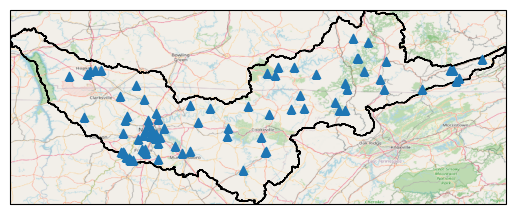

In [13]:
stations_fn = Path("../../data-cumberland/usgs_gage_locations/usgs_gages.csv")
stations = pd.read_csv(stations_fn, dtype={'site_no': str})
stations['geometry'] = gpd.GeoSeries.from_wkt(stations['geometry'])
stations = gpd.GeoDataFrame(stations)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import warnings
warnings.filterwarnings('ignore')

fn = Path('../../data-cumberland/Cumberland Boundary/Cumberland Boundary.shp')

def plot_map(fn, plot_stations=True, plot_boundary=True):
    gunnison_boundary = gpd.read_file(fn)
    gunnison_boundary.bounds.values[0]

    f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

    extent = gunnison_boundary.bounds[['minx', 'maxx', 'miny', 'maxy']].values[0]
    request = cimgt.OSM()
    ax.set_extent(extent)
    ax.add_image(request, 8)
    if plot_boundary:
        gunnison_boundary.plot(ax=ax, fc='none')
    if plot_stations:
        stations.plot(ax=ax, marker='^')

    return f, ax

f, ax = plot_map(fn)

ax

In [14]:
from rat.utils.utils import clip_ts

In [16]:
station = stations.iloc[21, :]

rat_inflow_fn = Path(f'../../data-cumberland/tennessee/basins/cumberland/ro/rout_inflow/{station["station_nm"][:3]}00.csv')
rat_inflow = pd.read_csv(rat_inflow_fn, parse_dates=['date']).set_index('date')

f, ax = plt.subplots()
rat_inflow['streamflow'].plot(ax=ax, label='Natural Inflow [VIC]')

obs_inflow_fn = Path(f'../../data-cumberland/usgs_insitu/{station["site_no"]}.csv')
obs_inflow = pd.read_csv(obs_inflow_fn, parse_dates=['datetime']).rename({'00060_Mean': 'streamflow', 'datetime': 'date'}, axis=1).set_index('date')

obs_inflow['streamflow'][obs_inflow['streamflow'] < 0] = np.nan
obs_inflow['streamflow'] = obs_inflow['streamflow'] * 0.0283168
obs_inflow, rat_inflow = clip_ts(obs_inflow.tz_localize(None), rat_inflow)
obs_inflow['streamflow'].plot(ax=ax, label='Observed [USGS]')

ax.legend()

# plot map
mf, ma = plot_map(fn)
# station.plot(ax=ma)
ma.scatter([station['geometry'].x], [station['geometry'].y], marker='^', color='orange')
ma

FileNotFoundError: [Errno 2] No such file or directory: '../../data-cumberland/tennessee/basins/cumberland/ro/rout_inflow/MAR00.csv'